# Generative Adversarial Networks (GANs) in Medical Imaging: Pneumonia

Generative Adversarial Networks (GANs) are a class of deep learning models that consist of two neural networks - a Generator and a Discriminator - that compete against each other in a minimax game. The Generator creates synthetic data samples, while the Discriminator tries to distinguish between real and generated samples. Through this adversarial process, the Generator learns to produce increasingly realistic data.

In medical imaging, GANs have several important applications:
- Data augmentation to address limited availability of medical images
- Synthetic data generation for rare conditions
- Domain adaptation between different imaging modalities
- Image enhancement and restoration

The notebook demonstrates how to implement a GAN for generating synthetic chest X-ray images of pneumonia using the PneumoniaMNIST dataset.

## Preparation

- Installs the medmnist package for accessing medical image datasets
- Imports necessary libraries for deep learning (PyTorch), data manipulation, and visualization
- Sets a random seed for reproducibility, ensuring the same results can be obtained across different runs

In [2]:
!pip install medmnist -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.2 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils

import medmnist
from medmnist import PneumoniaMNIST

# Set random seed for reproducibility
manualSeed = 999
torch.manual_seed(manualSeed)
np.random.seed(manualSeed)

## DataLoaders

- Defines data transformations to convert images to tensors and normalize them to the range [-1, 1], which is suitable for the Tanh activation in the Generator
- Downloads and loads the PneumoniaMNIST dataset, which contains chest X-ray images classified as normal or pneumonia
- Creates a DataLoader with a batch size of 128 and shuffling enabled for training
- Determines whether to use GPU (CUDA) or CPU for computation
- Visualizes a batch of training images to understand the data

100%|██████████| 4.17M/4.17M [00:06<00:00, 619kB/s]


Using device: cuda:0


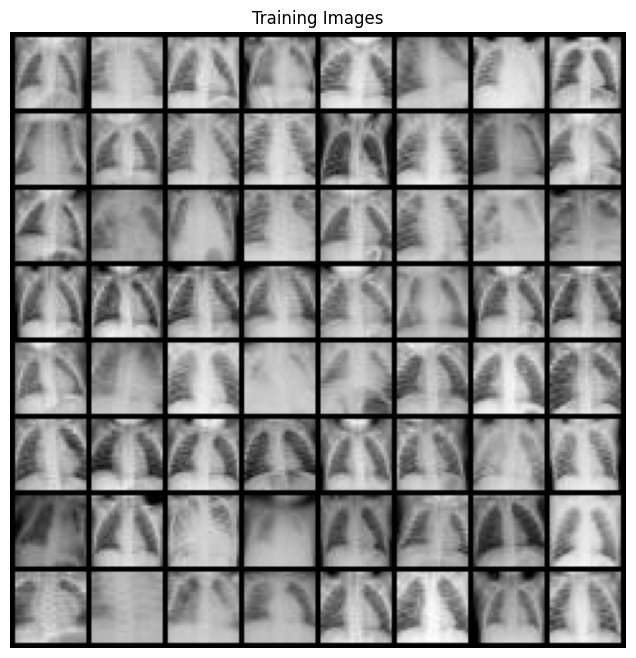

In [ ]:
# Data transformations
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5]) # Normalize to [-1, 1]
])

data_dir = '.' # Directory to save data
train_dataset = PneumoniaMNIST(split='train', transform=data_transform, download=True, root=data_dir)

batch_size = 128
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

## Model

Define key configuration parameters:
- `nz`: Size of the latent vector (random noise) input to the Generator (100 dimensions)
- `nc`: Number of channels in the images (1 for grayscale PneumoniaMNIST images)
- `ngf`: Size of feature maps in the Generator (controls network capacity)
- `img_size`: Total size of the flattened image (28×28 = 784 pixels)

In [ ]:
nz = 100
nc = 1
ngf = 64
img_size = 28 * 28

#### The Generator

- Takes random noise as input and transforms it into synthetic images
- Uses a fully connected (linear) architecture rather than convolutional layers, which is suitable for the relatively small 28×28 images
- Has 4 layers with increasing feature dimensions to progressively build up the image representation:
  1. First layer: Transforms latent vector (nz=100) to initial feature representation (ngf*4=256)
  2. Second layer: Expands features to ngf*8=512 with batch normalization for training stability
  3. Third layer: Further expands features to ngf*16=1024
  4. Output layer: Transforms to image dimensions (28*28=784 pixels)
- Uses LeakyReLU activations (with negative slope 0.2) for all hidden layers
- Uses Tanh activation in the output layer to produce values in the range [-1, 1], matching the normalized input data

In [ ]:
class Generator(nn.Module):
    def __init__(self, nz, ngf, img_size):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(nz, ngf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(ngf * 4, ngf * 8),
            nn.BatchNorm1d(ngf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(ngf * 8, ngf * 16),
            nn.BatchNorm1d(ngf * 16),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(ngf * 16, img_size),
            nn.Tanh()   # Output range [-1, 1]      
        )

    def forward(self, input):
        return self.main(input)

#### The Discriminator

- Takes an image as input and outputs a probability indicating whether the image is real or fake
- Also uses a fully connected architecture with 4 layers:
  1. First layer: Transforms flattened image (784 pixels) to initial feature representation (ndf*16=1024)
  2. Second layer: Compresses features to ndf*8=512
  3. Third layer: Further compresses features to ndf*4=256
  4. Output layer: Single value representing probability of being real
- Uses LeakyReLU activations for hidden layers
- Uses Sigmoid activation in the output layer to produce a probability between 0 and 1
- Flattens the input image in the forward pass before processing

In [ ]:
ndf = 64   

class Discriminator(nn.Module):
    def __init__(self, img_size, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(img_size, ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(ndf * 16, ndf * 8),
            nn.BatchNorm1d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(ndf * 8, ndf * 4),
            nn.BatchNorm1d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(ndf * 4, 1),
            nn.Sigmoid() # Output a probability (0-1)
        )

    def forward(self, input):
        # Flatten the image before passing to linear layers
        input = input.view(input.size(0), -1)
        return self.main(input)

## Initialize Models, Loss, and Optimizers

- Instantiates the Generator and Discriminator models and moves them to the selected device (GPU/CPU)
- Initializes Binary Cross Entropy (BCE) loss function, appropriate for binary classification tasks
- Creates a fixed batch of random noise vectors to track Generator progress during training
- Establishes label conventions: 1.0 for real images, 0.0 for fake images
- Sets up Adam optimizers for both networks with:
  - Learning rate of 0.0002
  - Beta1 of 0.5 (momentum parameter, lower than the default 0.9, as recommended in the DCGAN paper)
- Prints the model architectures for inspection

In [8]:
# Create the Generator
netG = Generator(nz, ngf, img_size).to(device)

# Create the Discriminator
netD = Discriminator(img_size, ndf).to(device)

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(64, nz, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
lr = 0.0002
beta1 = 0.5 # Recommended beta1 for Adam in DCGAN paper
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

print("Generator:", netG)
print("\nDiscriminator:", netD)

Generator: Generator(
  (main): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=512, out_features=1024, bias=True)
    (6): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=1024, out_features=784, bias=True)
    (9): Tanh()
  )
)

Discriminator: Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(neg

## Training

The training loop implements the GAN training process:

1. **Initialization**:
   - Creates lists to track progress: generated images, Generator losses, and Discriminator losses
   - Sets the number of training epochs to 50
   - Creates a directory to save generated images

2. **Training Process** (for each epoch and batch):
   - **Update Discriminator**:
     - Zero the gradients for Discriminator
     - Train with real images: Calculate loss for real images (should be classified as 1)
     - Train with fake images: Generate fake images, calculate loss (should be classified as 0)
     - Compute total Discriminator loss and update parameters
     - D(x) represents average prediction on real images (should be close to 1)
     - D(G(z)) represents average prediction on fake images (should be close to 0)

   - **Update Generator**:
     - Zero the gradients for Generator
     - Use fake labels as real for Generator cost (we want G to fool D)
     - Calculate Generator loss (wants D to predict 1 for fake images)
     - Update Generator parameters
     - D(G(z)) after update should increase as G improves

3. **Monitoring and Visualization**:
   - Print training statistics every 50 batches
   - Save losses for later plotting
   - Periodically generate and save images using fixed noise to track Generator progress

In [9]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

num_epochs = 50 # Adjust as needed, more epochs generally lead to better results but take longer

# Create directory for saving generated images
output_dir = "gan_pneumonia_images"
os.makedirs(output_dir, exist_ok=True)

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device) # data[0] contains the images
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1) # .detach() stops gradients flowing back to G
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1) # Don't detach fake here, we need gradients for G
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            # Reshape fake images back to 28x28 grayscale
            fake_images = fake.view(fake.size(0), 1, 28, 28) # Reshape to (batch_size, channels, height, width)
            img_grid = vutils.make_grid(fake_images, padding=2, normalize=True)
            img_list.append(img_grid)
            # Save the image grid
            vutils.save_image(img_grid, f"{output_dir}/fake_samples_epoch_{epoch:03d}_iter_{iters:05d}.png", normalize=True)

        iters += 1

print("Training Finished.")

Starting Training Loop...
[0/50][0/37]	Loss_D: 1.4279	Loss_G: 0.8550	D(x): 0.4443	D(G(z)): 0.4458 / 0.4271
[1/50][0/37]	Loss_D: 1.1149	Loss_G: 0.9031	D(x): 0.5763	D(G(z)): 0.4237 / 0.4072
[2/50][0/37]	Loss_D: 1.1463	Loss_G: 0.9196	D(x): 0.5625	D(G(z)): 0.4274 / 0.4037
[3/50][0/37]	Loss_D: 1.1417	Loss_G: 0.9164	D(x): 0.5632	D(G(z)): 0.4245 / 0.4046
[4/50][0/37]	Loss_D: 1.2516	Loss_G: 0.8529	D(x): 0.5435	D(G(z)): 0.4666 / 0.4300
[5/50][0/37]	Loss_D: 1.1568	Loss_G: 0.9296	D(x): 0.5485	D(G(z)): 0.4215 / 0.3976
[6/50][0/37]	Loss_D: 1.1829	Loss_G: 0.9387	D(x): 0.5649	D(G(z)): 0.4312 / 0.3967
[7/50][0/37]	Loss_D: 1.1970	Loss_G: 0.9118	D(x): 0.5402	D(G(z)): 0.4240 / 0.4120
[8/50][0/37]	Loss_D: 1.0962	Loss_G: 0.9194	D(x): 0.5940	D(G(z)): 0.4298 / 0.4048
[9/50][0/37]	Loss_D: 1.2201	Loss_G: 1.0090	D(x): 0.5344	D(G(z)): 0.4240 / 0.3825
[10/50][0/37]	Loss_D: 1.0380	Loss_G: 1.1401	D(x): 0.6005	D(G(z)): 0.3839 / 0.3540
[11/50][0/37]	Loss_D: 1.1598	Loss_G: 1.0876	D(x): 0.5278	D(G(z)): 0.3801 / 0.3458


## Results

- Plots the training losses for both Generator and Discriminator to visualize training progress
- Compares real and generated images side by side:
  - Left: A batch of real pneumonia X-ray images from the dataset
  - Right: The final batch of generated images from the trained Generator
- Provides a visual assessment of how well the GAN has learned to generate realistic pneumonia X-ray images

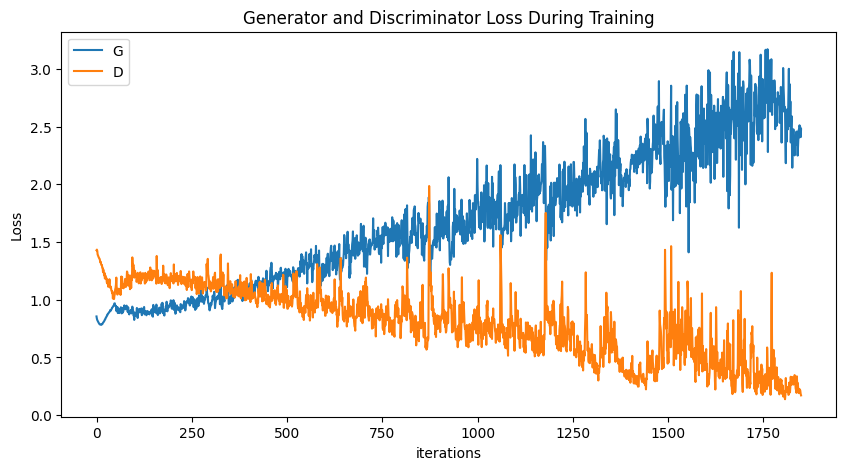

In [10]:
# Plot training losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

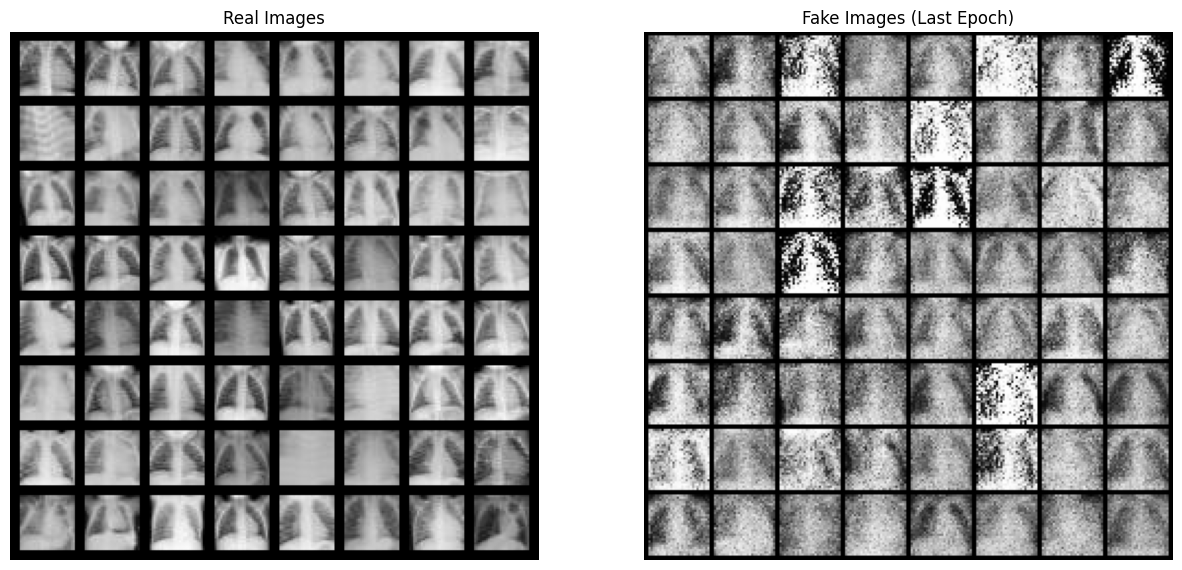

In [11]:
if img_list:
    # Grab a batch of real images from the dataloader
    real_batch = next(iter(dataloader))

    # Plot the real images
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

    # Plot the fake images from the last saved list item
    plt.subplot(1,2,2)
    plt.axis("off")
    plt.title("Fake Images (Last Epoch)")
    plt.imshow(np.transpose(img_list[-1],(1,2,0)))
    plt.show()
else:
    print("No generated images were saved during training (check training loop logic and iterations).")

# You can also view the saved image files in the 'gan_pneumonia_images' directory.

## Key Concepts in GAN Training

### Adversarial Training

The core of GAN training is the adversarial process:
1. The Discriminator learns to distinguish between real and fake images
2. The Generator learns to produce increasingly realistic images to fool the Discriminator
3. As training progresses, both networks improve their capabilities

### Loss Functions

- **Discriminator Loss**: Sum of two components:
  - Loss for real images: How well D classifies real images as real
  - Loss for fake images: How well D classifies fake images as fake
  - Ideal: D(x) ≈ 1 (real images classified as real) and D(G(z)) ≈ 0 (fake images classified as fake)

- **Generator Loss**: 
  - Based on how well G fools D into classifying fake images as real
  - Ideal: D(G(z)) ≈ 1 (fake images classified as real by D)

### Training Stability

GAN training can be unstable. This implementation includes several techniques to improve stability:
- Batch normalization in both networks
- LeakyReLU activations instead of standard ReLU
- Adam optimizer with beta1=0.5
- Proper initialization and normalization of input data

## Potential Improvements

1. **Architecture Enhancements**:
   - Use convolutional layers (DCGAN) for better image quality
   - Implement more advanced GAN variants like WGAN or StyleGAN

2. **Conditional Generation**:
   - Add condition labels to create a conditional GAN (cGAN)
   - Allow control over the type of images generated

3. **Evaluation Metrics**:
   - Implement quantitative metrics to evaluate generated image quality
   - Use medical-specific metrics for clinical relevance

4. **Applications**:
   - Use generated images for data augmentation in classification tasks
   - Explore domain adaptation between different medical imaging modalities

## Ethical Considerations

When using GANs for medical imaging:
- Synthetic images should be clearly labeled as such
- Careful evaluation is necessary before using in clinical applications
- Privacy concerns should be addressed when training on patient data
- Bias in the training data may be amplified in generated images

## Conclusion

This GAN implementation demonstrates the potential of generative models in medical imaging. While the current implementation uses a simple architecture, it provides a foundation for more advanced approaches that could address challenges in medical image analysis, such as limited data availability and class imbalance.